# TASK 3 - GMM

## Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

from sklearn.mixture import GaussianMixture
import pickle

from sklearn.neighbors import KernelDensity

## Import files

In [ ]:
df = pd.read_csv("ModifiedDATA/scaled_ra.csv")

In [4]:
# Subsample from the dataframe

sample_size = 20000
subsample = df.sample(sample_size)
sTrain = subsample[df.columns.difference(["id","group"])]

## Model selection

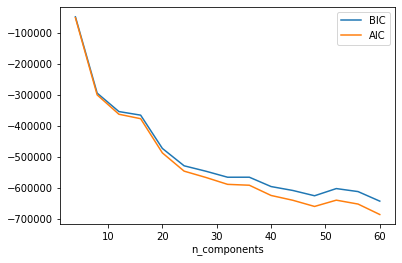

In [9]:
# fit the models
n_components = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60]
gmms = [GaussianMixture(n_components=k).fit(sTrain) for k in n_components]

# plot the bics and aics
bics = [gmm.bic(sTrain) for gmm in gmms]
aics = [gmm.aic(sTrain) for gmm in gmms]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()
plt.show()


## Fit a GMM with 8 and 36 components on diseased and control groups

In [6]:
%%time
G8s = {"control": None,"diseased": None}
G36s = {"control": None ,"diseased": None}

for g in ["control","diseased"]:
    group = df[df.group == g]
    group_cells = group[group.columns.difference(["id","group"])]

    G8s[g] = GaussianMixture(n_components=8).fit(X = group_cells, y = None)
    G36s[g] = GaussianMixture(n_components=36).fit(X = group_cells, y = None)


CPU times: user 27min 51s, sys: 3min 20s, total: 31min 12s
Wall time: 16min 48s


### Save the models to a file

In [21]:
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

In [22]:
def save_models(nr_comp, model_groups):
    for group in model_groups:
        model = model_groups[group]
        filename = "ModifiedDATA/GMM{0}_{1}.pkl".format(nr_comp, group)
        save_model(model, filename)

In [26]:
save_models(8,G8s)
save_models(36,G36s)

### Load the models from file

In [13]:
help(pickle.dump)

Help on built-in function dump in module _pickle:

dump(obj, file, protocol=None, *, fix_imports=True)
    Write a pickled representation of obj to the open file object file.
    
    This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
    be more efficient.
    
    The optional *protocol* argument tells the pickler to use the given
    protocol supported protocols are 0, 1, 2, 3 and 4.  The default
    protocol is 3; a backward-incompatible protocol designed for Python 3.
    
    Specifying a negative protocol version selects the highest protocol
    version supported.  The higher the protocol used, the more recent the
    version of Python needed to read the pickle produced.
    
    The *file* argument must have a write() method that accepts a single
    bytes argument.  It can thus be a file object opened for binary
    writing, an io.BytesIO instance, or any other custom object that meets
    this interface.
    
    If *fix_imports* is True and protocol is less

In [18]:
def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [25]:
load_model('ModifiedDATA/GMM8_control.pkl')

GaussianMixture(n_components=8)

In [24]:
G8s_ = {"control": load_model('ModifiedDATA/GMM8_control.pkl'),"diseased": load_model('GMM8_diseased.sav')}
G36s_ = {"control": load_model('GMM36_control.sav') ,"diseased": load_model('GMM36_diseased.sav')}

UnicodeDecodeError: 'ascii' codec can't decode byte 0x84 in position 1: ordinal not in range(128)

## Generate data from the GMMs 

In [25]:
def generate_patients(gmm, sample_size, nr_patients):
    """
    PARAMETERS:
    ----------
    gmm (fitted GaussianMixture object): 
    sample_size (int): number of cells per patient
    nr_patients (int): number of patients to generate
    
    RETURNS:
    -------
    patients (array): list of patients, each patient with `sample_size` cells.
    """
    patients = np.array([gmm.sample(sample_size)[0] for i in range(nr_patients)])
    return patients
        

In [26]:
sample_size = 20000 # this represents one patient
nr_patients = 20

G8_patients = {"control": generate_patients(G8s["control"],sample_size, nr_patients),
                  "diseased":  generate_patients(G8s["diseased"],sample_size, nr_patients)}

G36_patients = {"control":  generate_patients(G36s["control"],sample_size, nr_patients), 
                   "diseased": generate_patients(G36s["diseased"],sample_size, nr_patients)}




### Save generated patients

In [28]:
np.save("GeneratedDATA/G8_patients", G8_patients)
np.save("GeneratedDATA/G36_patients", G36_patients)

In [2]:
G8_patients = np.load("GeneratedDATA/G8_patients.npy")

ValueError: Object arrays cannot be loaded when allow_pickle=False